# 📈 Prévision des cours boursiers avec ARIMA et LSTM
Projet hybride de prévision utilisant des modèles linéaires (ARIMA) et non-linéaires (LSTM).

##  Installation des bibliothèques nécessaires

In [1]:
!pip install yfinance pmdarima statsmodels tensorflow scikit-learn matplotlib seaborn

## 📦 Importation des bibliothèques

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

##  Téléchargement des données financières

C:\Users\icoco\AppData\Local\Temp\ipykernel_36252\3177462027.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2015-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


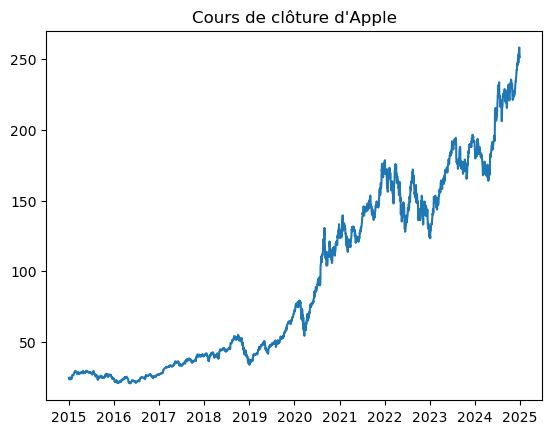

In [3]:
data = yf.download('AAPL', start='2015-01-01', end='2024-12-31')
data = data[['Close']].dropna()
plt.plot(data)
plt.title("Cours de clôture d'Apple")
plt.show()

##  Modélisation ARIMA pour la tendance linéaire

In [4]:
model_arima = auto_arima(data, seasonal=False, trace=True)
arima = ARIMA(data, order=model_arima.order)
arima_fit = arima.fit()
data['ARIMA_Pred'] = arima_fit.predict(start=0, end=len(data)-1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10434.134, Time=11.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10430.530, Time=0.62 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10432.047, Time=1.87 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10432.018, Time=2.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10434.072, Time=0.50 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10432.429, Time=8.76 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 25.701 seconds


C:\Users\icoco\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\icoco\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\icoco\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


##  Extraction des résidus pour le modèle LSTM

In [5]:

data['residuals'] = data['Close'].iloc[:, 0] - data['ARIMA_Pred']


residuals = data['residuals'].dropna().values.reshape(-1, 1)

scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(residuals)

def create_sequences(data, step):
    x, y = [], []
    for i in range(step, len(data)):
        x.append(data[i-step:i])
        y.append(data[i])
    return np.array(x), np.array(y)

look_back = 10
X_lstm, y_lstm = create_sequences(residuals_scaled, look_back)
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

In [6]:
print("Shape X :", X_lstm.shape)
print("Shape y :", y_lstm.shape)


Shape X : (2505, 10, 1)
Shape y : (2505, 1)


##  Entraînement du modèle LSTM sur les résidus

In [7]:
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(look_back, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_lstm, y_lstm, epochs=20, batch_size=32)

C:\Users\icoco\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - loss: 0.0287
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0033
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0030
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0031
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0034
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0032
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0031
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0032
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0031
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0028
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0032
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0031
Epoch 13/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0031
Epoch 14/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0032
Epoch 15/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0032
Epo

##  Reconstruction des prédictions finales

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step


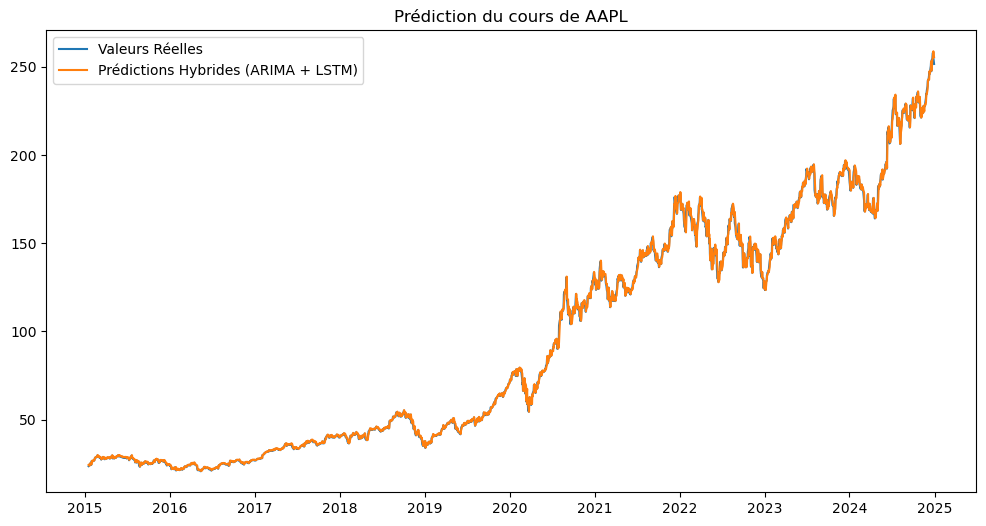

In [8]:
pred_residuals = model.predict(X_lstm)
pred_residuals_inv = scaler.inverse_transform(pred_residuals)

full_pred = data['ARIMA_Pred'].iloc[look_back:].values + pred_residuals_inv.flatten()
true = data['Close'].iloc[look_back:]

plt.figure(figsize=(12,6))
plt.plot(true.index, true.values, label='Valeurs Réelles')
plt.plot(true.index, full_pred, label='Prédictions Hybrides (ARIMA + LSTM)')
plt.legend()
plt.title("Prédiction du cours de AAPL")
plt.show()

## Évaluation des performances

In [9]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(true, full_pred))
print(f"RMSE du modèle hybride : {rmse:.2f}")

RMSE du modèle hybride : 1.93


In [10]:
import os

if not data.index.name or "date" not in data.index.name.lower():
    data.index.name = "Date"

df = data.reset_index()

columns_to_keep = ['Date', 'Close', 'ARIMA_Pred', 'residuals']
df = df[[col for col in columns_to_keep if col in df.columns]]

os.makedirs("data", exist_ok=True)

df.to_csv("data/df.csv", index=False)
print("✅ Fichier exporté avec succès pour Streamlit")


✅ Fichier exporté avec succès pour Streamlit


In [11]:

os.getcwd()


'C:\\Users\\icoco'

##  Ajout d'indicateurs techniques (RSI, MACD, EMA)

In [12]:
!pip install ta

In [13]:
#df['Close'] = df['Close'].squeeze()  
#df['Close'] = pd.Series(df['Close'].values.ravel(), index=df.index)
close_series = pd.Series(df['Close'].values.ravel(), index=df.index)
df = df.drop(columns='Close')  
df['Close'] = close_series     

print(type(df['Close']))
print(df['Close'].shape)

<class 'pandas.core.series.Series'>
(2515,)


C:\Users\icoco\AppData\Local\Temp\ipykernel_36252\527730753.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.drop(columns='Close')  # On enlève l'ancienne colonne DataFrame


In [14]:

import ta

df = df.dropna()

# Ajout des indicateurs techniques
df['rsi'] = ta.momentum.RSIIndicator(close=df['Close']).rsi()
df['ema_20'] = ta.trend.EMAIndicator(close=df['Close'], window=20).ema_indicator()
df['macd'] = ta.trend.MACD(close=df['Close']).macd()

df.dropna(inplace=True)
df.head()
    

Price,Date,ARIMA_Pred,residuals,Close,rsi,ema_20,macd
Ticker,,,,,,,
25,2015-02-09,26.525579,0.176195,26.701775,66.460312,25.610447,0.634479
26,2015-02-10,26.701775,0.512980,27.214754,70.229490,25.763238,0.681845
27,2015-02-11,27.214754,0.637880,27.852634,74.123656,25.962229,0.762070
28,2015-02-12,27.852634,0.352394,28.205029,75.992005,26.175829,0.844351
29,2015-02-13,28.205029,0.138285,28.343313,76.702871,26.382256,0.910225


##  Split des données et Évaluation

In [15]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

split_index = int(len(df) * 0.8)
train = df.iloc[:split_index]
test = df.iloc[split_index:]

y_true = test['Close']
y_pred = test['ARIMA_Pred']
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    

RMSE: 2.5445, MAE: 1.8866, R²: 0.9915


##  Courbe interactive dans Streamlit avec Plotly

In [16]:

import plotly.graph_objects as go
import streamlit as st

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], mode='lines', name='Réel'))
fig.add_trace(go.Scatter(x=df['Date'], y=df['ARIMA_Pred'], mode='lines', name='Prédiction ARIMA'))

st.plotly_chart(fig, use_container_width=True)
    

2025-06-24 01:45:09.607 
  command:

    streamlit run C:\Users\icoco\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()

##  Dashboard Streamlit avancé

In [17]:

selected_model = st.selectbox("Choix du modèle", ["ARIMA", "LSTM", "Hybride"])
horizon = st.slider("Horizon de prédiction (jours)", 1, 30, 7)

    

2025-06-24 01:45:10.201 Session state does not function when running a script without `streamlit run`


In [18]:
df.to_csv("df.csv", index=False)


In [19]:



if isinstance(df['Close'], pd.DataFrame):
    df['Close'] = df['Close'].iloc[:, 0]
else:
    df['Close'] = df['Close']

macd_indicator = ta.trend.MACD(close=df['Close'])
df['macd'] = macd_indicator.macd()
df['macd_signal'] = macd_indicator.macd_signal()


In [20]:
def generate_signal(row):
    macd = row['macd']
    signal = row['macd_signal']

    # S'assurer qu'on compare des scalaires
    if hasattr(macd, 'item'):
        macd = macd.item()
    if hasattr(signal, 'item'):
        signal = signal.item()

    if macd > signal:
        return "Buy"
    elif macd < signal:
        return "Sell"
    else:
        return "Hold"

df['signal'] = df.apply(generate_signal, axis=1)


In [21]:

#Génération des signaux Buy/Sell/Hold à partir du MACD et de sa ligne de signal
def generate_signal(row):
    macd = row['macd']
    signal = row['macd_signal']
    if macd > signal:
        return "Buy"
    elif macd < signal:
        return "Sell"
    else:
        return "Hold"

df['signal'] = df.apply(generate_signal, axis=1)

# Sauvegarde du DataFrame mis à jour
df.to_csv("df_signals.csv", index=False)

#Vérification de l'ajout
df[['Date', 'macd', 'macd_signal', 'signal']].tail()


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().